# Tutorial 3. Use SEDR to do batch integration.

Here we use 3 sections from DLPFC data to show the ability of SEDR to integrate batches for the same tissue with the same techniques. 

In [1]:
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os,csv,re
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
from pathlib import Path
from sklearn import metrics
from pathlib import Path
from tqdm import tqdm

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
import SEDR

In [3]:
data_root = Path('../data/BaristaSeq/')

proj_list = [
    'Slice_1_removed.h5ad', 'Slice_2_removed.h5ad', 'Slice_3_removed.h5ad'
]

# '151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675','151676'

In [4]:
# adata = sc.read('../data/BaristaSeq/Slice_1_removed.h5ad')

In [5]:
# adata

## Combining datasets

Input of SEDR includes an AnnData object that contains the spatial transcriptomics data and a graph dictionary that contains the neighborhood graph. When combining two datasets, the AnnData objects are directly concatenated. For neighborhood graphs, we follow the following algorithm.  
Let $A^k$ and $Z_f^k$ denote the adjacency matrix and deep gene representation of spatial omics k, we then create a block-diagonal adjacency matrix $A^k$  and concatenate the deep gene representation in the spot dimension, as:  
![](batch_integration.png)  
where K is the number of spatial omics. 


In [6]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read(data_root / proj_name)
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    graph_dict_tmp = SEDR.graph_construction(adata_tmp, 12)
    
    ##### Load layer_guess label, if have
    # df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
    # adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    # adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        graph_dict = SEDR.combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name
    print(adata.X.shape)

 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 1/3 [00:00<00:00,  3.51it/s]

(1525, 79)


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2/3 [00:00<00:00,  2.71it/s]

(3567, 79)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]

(5257, 79)


## Preprocessing

In [7]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

x_pixel = adata.obsm['spatial'][:,0]
y_pixel = adata.obsm['spatial'][:,1]
adj = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)

Calculateing adj matrix using xy only...


In [8]:
adata.X.shape

(5250, 79)

In [9]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 4523.667294345421]
Run 2: l [0.01, 500.005], p [0.0, 3187.1435546875]
Run 3: l [0.01, 250.0075], p [0.0, 1473.7952880859375]
Run 4: l [0.01, 125.00874999999999], p [0.0, 484.3749084472656]
Run 5: l [0.01, 62.509375], p [0.0, 135.9563751220703]
Run 6: l [0.01, 31.2596875], p [0.0, 35.60138702392578]
Run 7: l [0.01, 15.63484375], p [0.0, 8.871190071105957]
Run 8: l [0.01, 7.822421875], p [0.0, 2.0446958541870117]
Run 9: l [3.9162109375, 7.822421875], p [0.4201911687850952, 2.0446958541870117]
Run 10: l [3.9162109375, 5.86931640625], p [0.4201911687850952, 1.0708417892456055]
Run 11: l [3.9162109375, 4.8927636718750005], p [0.4201911687850952, 0.7036654949188232]
Run 12: l [3.9162109375, 4.4044873046875], p [0.4201911687850952, 0.5513691902160645]
Run 13: l [4.16034912109375, 4.4044873046875], p [0.48314356803894043, 0.5513691902160645]
Run 14: l [4.16034912109375, 4.282418212890625], p [0.48314356803894043, 0.5165959596633911]
recommended l =  4.22138366699

In [10]:
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  8
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  5
Step changed to 0.05
Initializing cluster centers with louvain, resolution =  0.6499999999999999
Epoch  0
Epoch  10
Res =  0.6499999999999999 Num of clusters =  7
recommended res =  0.6499999999999999


In [11]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obsm['feature'] = prob
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  0.6499999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190


## use harmony to calculate revised PCs

In [12]:
import harmonypy as hm

meta_data = adata.obs[['batch']]

data_mat = adata.obsm['feature']
vars_use = ['batch']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df

2025-04-07 21:34:59,109 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-07 21:35:00,541 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-07 21:35:00,682 - harmonypy - INFO - Iteration 1 of 10
2025-04-07 21:35:01,552 - harmonypy - INFO - Iteration 2 of 10
2025-04-07 21:35:02,340 - harmonypy - INFO - Iteration 3 of 10
2025-04-07 21:35:03,122 - harmonypy - INFO - Iteration 4 of 10
2025-04-07 21:35:03,340 - harmonypy - INFO - Iteration 5 of 10
2025-04-07 21:35:03,561 - harmonypy - INFO - Converged after 5 iterations


## Visualizing

### UMAP

In [13]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata, min_dist=0.2)

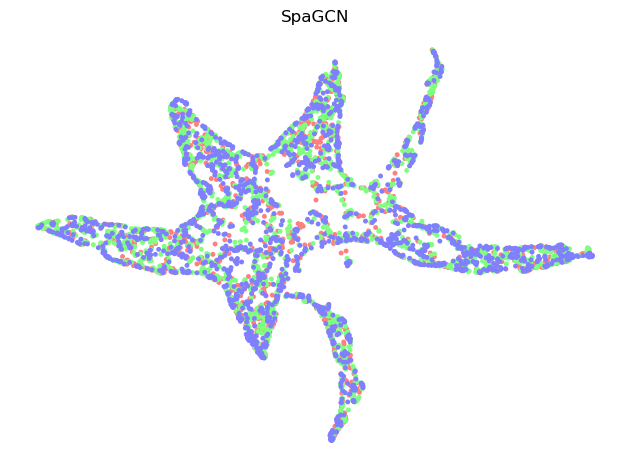

In [14]:
sc.pl.umap(
    adata, 
    color=['batch_name'], 
    palette=['#FF7F7F', '#7FFF7F', '#7F7FFF'], 
    show=False, 
    size=50, 
    frameon=False,  # 去掉外边框
    legend_loc='left margin',  # 调整图例位置
    title="SpaGCN" 
)

# 获取当前图形并修改散点样式
ax = plt.gca()
for path in ax.spines.values():  
    path.set_visible(True)  # 显示边框
    path.set_linewidth(0)   # 设置边框粗细

# 手动调整点的边框颜色
scatter = ax.collections[0]  # 获取散点图
scatter.set_edgecolor('white')  # 设置边框颜色
scatter.set_linewidth(0)  # 设置边框宽度
plt.tight_layout()
plt.savefig('umap_batch.svg', format='svg')
plt.show()

### LISI score

In [15]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch']], label_colnames=['batch'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['Region']], label_colnames=['Region'])[:, 0]

In [16]:
mean_ILISI = np.mean(np.array(ILISI))
mean_CLISI = np.mean(np.array(CLISI))
print("mean_ILISI:", mean_ILISI)
print("mean_CLISI:", mean_CLISI)

mean_ILISI: 1.6676949735251407
mean_CLISI: 2.53473464987313


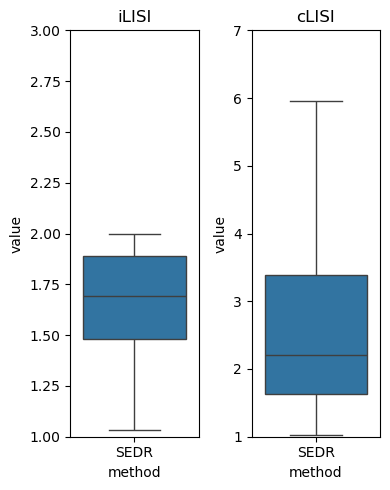

In [17]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI']*len(CLISI)
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()